## Mini_project  Module 3  - Forecasting models for traffic accidents

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns


import sklearn
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, balanced_accuracy_score


### Import des fichiers de données

In [2]:
carac = pd.read_csv("./data/caracteristiques-2019.csv", sep=";") # nous donne des caractéristiques sur les accidents
lieux = pd.read_csv("./data/lieux-2019.csv", sep=";") # recense des données sur les lieux des accidents
veh = pd.read_csv("./data/vehicules-2019.csv", sep=";") # donne des informations sur les véhicules impliqués
vict = pd.read_csv("./data/usagers-2019.csv", sep=";") # donne des informations sur les victimes

In [3]:
print(f'Forme de carac = {carac.shape}')
print(f'Forme de lieux = {lieux.shape}')
print(f'Forme de veh = {veh.shape}')
print(f'Forme de vict = {vict.shape}')

Forme de carac = (58840, 15)
Forme de lieux = (58840, 18)
Forme de veh = (100710, 11)
Forme de vict = (132977, 15)


In [4]:
print(set(veh.columns).intersection(set(lieux.columns).intersection(set(carac.columns).intersection(set(vict.columns)))))
print(set(veh.columns).intersection(set(vict.columns)))

{'Num_Acc'}
{'Num_Acc', 'id_vehicule', 'num_veh'}


**Observations**

Les 4 fichiers ont en commun la colonne 'NumAcc' (numéro d'accident).

Les fichiers 'veh' et 'vict' ont en commun 2 autres colonnes : 'num_veh' (identifiant de véhicule) et 'id_vehicule' (identifiant unique du véhicule). 

In [5]:
print("'carac' file:")
print(f"Number of NumAcc unique values = {carac.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(carac.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(carac)}')
print()
print("'lieux' file:")
print(f"Number of NumAcc unique values = {lieux.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(lieux.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(lieux)}')
print()
print("'veh' file:")
print(f"Number of NumAcc unique values = {veh.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(veh.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(veh)}')
print()
print("'vict' file:")
print(f"Number of NumAcc unique values = {vict.Num_Acc.nunique()}")
print(f'Max count by NumAcc unique value = {max(list(vict.Num_Acc.value_counts().values))}')
print(f'Number of rows = {len(vict)}')
print()

'carac' file:
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 1
Number of rows = 58840

'lieux' file:
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 1
Number of rows = 58840

'veh' file:
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 12
Number of rows = 100710

'vict' file:
Number of NumAcc unique values = 58840
Max count by NumAcc unique value = 33
Number of rows = 132977



**Observations**

A ce stade on peut supposer que : 
- chaque fichier recense les mêmes 58140 accidents distincts, identifiés par un identifiant unique. 
- ces 58140 accidents sont survenus chacun dans un lieu distinct (d'où 58140 lieux distincts), ont impliqué un nombre de véhicules plus ou moins grand (de 1 à 12) et occasionné un nombre de victimes plus ou moins grand (de 1 à 33).
Pour confirmer ces chiffres, nous devrons au préalable supprimer les éventuelles lignes en double dans chaque fichier.

### Fusion des fichiers

Notre étude porte sur la gravité des accidents pour les victimes, nous souhaitons donc disposer d'un fichier unique qui comptera 1 ligne par victime distincte.
Nous fusionnons donc le fichier 'vict' avec les 3 autres en excluant les lignes supplémentaires éventuelles de ces autres fichiers.

In [6]:
victime = (vict.merge(veh,
                      on=['Num_Acc','num_veh','id_vehicule'], 
                      how='left')
           .merge(carac,
                  on = 'Num_Acc', 
                  how='left')
           .merge(lieux, 
                  on=['Num_Acc'], 
                  how='left'))


### Premières observations sur le fichier

In [7]:
victime.shape

(132977, 54)

In [8]:
victime.duplicated().sum()

101

In [9]:
victime = victime.drop_duplicates()
victime.shape

(132876, 54)

In [10]:
victime.head()

,Num_Acc,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,...,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,201900000001,138 306 524,B01,2,2,4,2,2002,0,1,...,1,6,900,2,NaN,NaN,1,2,1,70
1,201900000001,138 306 524,B01,1,1,4,2,1993,5,1,...,1,6,900,2,NaN,NaN,1,2,1,70
2,201900000001,138 306 525,A01,1,1,1,1,1959,0,1,...,1,6,900,2,NaN,NaN,1,2,1,70
3,201900000002,138 306 523,A01,1,1,4,2,1994,0,1,...,4,3,845,2,NaN,NaN,1,0,1,70
4,201900000003,138 306 520,A01,1,1,1,1,1996,0,1,...,1,10,500,3,NaN,NaN,1,0,1,90


In [11]:
victime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132876 entries, 0 to 132976
Data columns (total 54 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      132876 non-null  int64  
 1   id_vehicule  132876 non-null  object 
 2   num_veh      132876 non-null  object 
 3   place        132876 non-null  int64  
 4   catu         132876 non-null  int64  
 5   grav         132876 non-null  int64  
 6   sexe         132876 non-null  int64  
 7   an_nais      132876 non-null  int64  
 8   trajet       132876 non-null  int64  
 9   secu1        132876 non-null  int64  
 10  secu2        132876 non-null  int64  
 11  secu3        132876 non-null  int64  
 12  locp         132876 non-null  int64  
 13  actp         132876 non-null  object 
 14  etatp        132876 non-null  int64  
 15  senc         132876 non-null  int64  
 16  catv         132876 non-null  int64  
 17  obs          132876 non-null  int64  
 18  obsm         132876 non-

**Observations**
- La plupart des données sont catégorielles, et codifiées sous forme de chiffre de 1 à 10.
- Plusieurs colonnes sont en format "objet". En vue du traitement ultérieur de machine learning, nous devons convertir en format numérique celles dont le contenu est chiffré. 
- Nous observons des colonnes dont les valeurs sont manquantes, nous devrons y remédier.
- Nous commencerons par la conversion en format numérique des colonnes, celle-ci étant susceptible de générer des valeurs manquantes.

In [12]:
victime.columns

Index(['Num_Acc', 'id_vehicule', 'num_veh', 'place', 'catu', 'grav', 'sexe',
       'an_nais', 'trajet', 'secu1', 'secu2', 'secu3', 'locp', 'actp', 'etatp',
       'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor', 'occutc',
       'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'agg', 'int', 'atm',
       'col', 'adr', 'lat', 'long', 'catr', 'voie', 'v1', 'v2', 'circ', 'nbv',
       'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf',
       'infra', 'situ', 'vma'],
      dtype='object')

### Preprocessing 

**Etude de la nature des variables - Sélection de colonnes**
Les variables suivantes ne nous paraissent pas de nature à influencer positivement la classification de la variable cible (non pertinence ou risque de surapprentissage/overfitting). Nous choisissons de les écarter : - année de naissance de la victime, nombre d'occupants du transport en commpun, jour de l'accident (on garde le mois), heure/min de l'accident (on garde l'éclairage), adresse postale et code insee de la commune (on garde le département et la distinction agglo/hors agglo), indices du numéro de voie v1 et v2, pr et pr1 (n° du point de repère le plus proche et distance au point), voie (numéro de la route).

In [13]:
victime.drop(['an_nais', 'occutc', 'jour', 'hrmn', 'adr', 'com', 'v1', 'v2', 'pr', 'pr1', 'voie'], axis=1, inplace=True)

#check
print(victime.shape)

(132876, 43)


**Unités de valeur**
La plupart des informations sont présentées sous forme de code numérique (par exemple 0='jaune', 1='rouge', 2=bleu, etc.)
Dans ce code, le "-1" signifie toujours "valeur non renseignée".

**Format des colonnes**

In [14]:
print(f'Initialement, {len(list(victime.dtypes[victime.dtypes == object]))} colonnes sont au format "objet" : {list(victime.dtypes[victime.dtypes == object].index)}')

Initialement, 6 colonnes sont au format "objet" : ['id_vehicule', 'num_veh', 'actp', 'dep', 'lat', 'long']


**Observations**

La série 'id_véhicule' doit être nettoyée pour pouvoir être convertie en format numérique.

In [15]:
victime.loc[0,'id_vehicule']

'138\xa0306\xa0524'

In [16]:
from unicodedata import normalize
import re
def clean_up(text):
    text = normalize('NFKD', text)
    text = re.sub('\W*','',text)
    return int(text)

victime['id_vehicule'] = victime['id_vehicule'].apply(clean_up)

#check
victime['id_vehicule'].dtypes

dtype('int64')

In [17]:
victime.loc[:5,'id_vehicule']

0    138306524
1    138306524
2    138306525
3    138306523
4    138306520
5    138306520
Name: id_vehicule, dtype: int64

**Observations**

In [18]:
victime.vma.isna().sum()

0

In [19]:
aconvertir = ['actp','dep']
print(f"Les colonnes suivantes peuvent être directement converties au format numérique : {aconvertir}")

Les colonnes suivantes peuvent être directement converties au format numérique : ['actp', 'dep']


In [20]:
def convert_to_numeric(col):
    victime[col] = pd.to_numeric(victime[col], errors='coerce')

for c in aconvertir:
    convert_to_numeric(c) 

print(victime.dtypes)

Num_Acc          int64
id_vehicule      int64
num_veh         object
place            int64
catu             int64
grav             int64
sexe             int64
trajet           int64
secu1            int64
secu2            int64
secu3            int64
locp             int64
actp           float64
etatp            int64
senc             int64
catv             int64
obs              int64
obsm             int64
choc             int64
manv             int64
motor            int64
mois             int64
an               int64
lum              int64
dep            float64
agg              int64
int              int64
atm              int64
col              int64
lat             object
long            object
catr             int64
circ             int64
nbv              int64
vosp             int64
prof             int64
plan             int64
lartpc         float64
larrout        float64
surf             int64
infra            int64
situ             int64
vma              int64
dtype: obje

In [21]:
print(f"Les {len(list(victime.dtypes[victime.dtypes == object].index))} dernières colonnes comprennent par nature du texte, et resteront au format 'objet' :")
print(list(victime.dtypes[victime.dtypes == object].index))

Les 3 dernières colonnes comprennent par nature du texte, et resteront au format 'objet' :
['num_veh', 'lat', 'long']


In [22]:
print(f"Nous avons donc, dans notre jeu de données, {len(list(victime.dtypes[victime.dtypes == object].index))} colonnes de type 'texte' et {len(list(victime.dtypes[victime.dtypes != object].index))} de type 'chiffre' (entier ou décimal).")

Nous avons donc, dans notre jeu de données, 3 colonnes de type 'texte' et 40 de type 'chiffre' (entier ou décimal).


**Valeurs manquantes**

Les valeurs manquantes sont repérées par la valeur 'NaN', mais également par la valeur '-1' dont le référentiel nous indique qu'elle signifie "non renseigné". 
Par ailleurs, la feature "trajet" utilise le code "0" pour indiquer les valeurs manquantes. 
Afin de comptabiliser l'intégralité des valeurs manquantes, on remplace ces chiffres par 'NaN'.

In [23]:
victime.replace(-1,np.NaN, inplace=True)

In [24]:
victime.trajet.replace(0,np.NaN, inplace=True)

Imprimons toutes les colonnes qui comprennent des valeurs manquantes.

In [25]:
percent_missing = victime.isna().sum() * 100 / len(victime)
missing_value_df = pd.DataFrame({'column_name': victime.columns, 'missing_percent': percent_missing}).sort_values(by='missing_percent', ascending=False).reset_index(drop=True)
missing_value_df = missing_value_df[missing_value_df['missing_percent']>0]
missing_value_df

,column_name,missing_percent
0,lartpc,99.648545
1,larrout,99.374605
2,secu3,98.679972
3,etatp,91.704296
4,locp,37.976008
5,secu2,30.186038
6,trajet,26.265089
7,actp,20.225624
8,circ,5.058099
9,vma,1.428399


Supprimons les colonnes qui contiennent plus de 10% de valeurs manquantes : 
lartpc, larrout, secu3, etatp, locp, secu2, trajet, actp

In [26]:
missing_value_df_morethan10 = missing_value_df[(missing_value_df['missing_percent']>10)]

In [27]:
missing_value_df_morethan10

,column_name,missing_percent
0,lartpc,99.648545
1,larrout,99.374605
2,secu3,98.679972
3,etatp,91.704296
4,locp,37.976008
5,secu2,30.186038
6,trajet,26.265089
7,actp,20.225624


In [28]:
missing_value_df_morethan10_list = list(missing_value_df_morethan10['column_name'])

In [29]:
victime.drop(columns=missing_value_df_morethan10_list, axis = 1, inplace = True)

In [30]:
percent_missing = victime.isna().sum() * 100 / len(victime)
missing_value_df = pd.DataFrame({'column_name': victime.columns, 'missing_percent': percent_missing}).sort_values(by='missing_percent', ascending=False).reset_index(drop=True)
missing_value_df = missing_value_df[missing_value_df['missing_percent']>0]
missing_value_df

,column_name,missing_percent
0,circ,5.058099
1,vma,1.428399
2,dep,1.082965
3,vosp,1.075439
4,nbv,1.056624
5,motor,0.278455
6,situ,0.170836
7,infra,0.074506
8,obsm,0.066980
9,secu1,0.066227


Ensuite, suppprimons les lignes dont les valeurs manquantes représentent moins d'1% de leurs colonnes respectives.

In [31]:
missing_value_df_lessthan1 = missing_value_df[(missing_value_df['missing_percent']>0)&(missing_value_df['missing_percent']<1)]
missing_list = list(missing_value_df_lessthan1['column_name'])

for i in range(len(missing_list)):
    if len(missing_list)>0:
        victime.dropna(subset=[missing_list[0]], inplace=True)
        victime.reset_index(drop=True)
        missing_value_df = pd.DataFrame({'column_name': victime.columns, 'missing_percent': victime.isna().sum() * 100 / len(victime)}).sort_values(by='missing_percent', ascending=False).reset_index(drop=True)
        missing_value_df_lessthan1 = missing_value_df[(missing_value_df['missing_percent']>0) & (missing_value_df['missing_percent']<1)]
        missing_list = list(missing_value_df_lessthan1['column_name'])
    else:
        break

percent_missing = victime.isna().sum() * 100 / len(victime)
missing_value_df = pd.DataFrame({'column_name': victime.columns, 'missing_percent': percent_missing}).sort_values(by='missing_percent', ascending=False).reset_index(drop=True)
missing_value_df = missing_value_df[missing_value_df['missing_percent']>0]
missing_value_df

,column_name,missing_percent
0,circ,4.776110
1,dep,1.103303
2,vma,1.051021


In [32]:
print(f"{len(missing_value_df)} colonnes ont un ratio de valeurs manquantes comprises entre 1 et 10%.")
print("Nous décidons de remplacer les valeurs manquantes des séries catégorielles par la valeur majoritaire, et celles des séries numériques par la médiane.")
print("Nous remplaçons les numéros de département qui manquent par la valeur 0 (inconnu).")

3 colonnes ont un ratio de valeurs manquantes comprises entre 1 et 10%.
Nous décidons de remplacer les valeurs manquantes des séries catégorielles par la valeur majoritaire, et celles des séries numériques par la médiane.
Nous remplaçons les numéros de département qui manquent par la valeur 0 (inconnu).


In [33]:
victime.dep.fillna(0, inplace=True)
victime.circ.fillna(victime.circ.mode()[0], inplace=True)
victime.vma.fillna(victime.vma.median(), inplace=True)

percent_missing = victime.isna().sum() * 100 / len(victime)
missing_value_df = pd.DataFrame({'column_name': victime.columns, 'missing_percent': percent_missing}).sort_values(by='missing_percent', ascending=False).reset_index(drop=True)
missing_value_df = missing_value_df[missing_value_df['missing_percent']>0]

Vérifions que notre jeu de données ne comprend plus aucune valeur manquante :

In [34]:
if victime.isna().sum().any() == False:
    print('Plus de valeur manquante dans le jeu de données.')
else:
    print(victime.isna().sum())

Plus de valeur manquante dans le jeu de données.


In [35]:
victime.shape

(130064, 35)

**Valeurs aberrantes**

Repérons et traitons les valeurs aberrantes.

In [36]:
victime.max()

Num_Acc        201900058840
id_vehicule       138306525
num_veh                 \01
place                    10
catu                      3
grav                      4
sexe                      2
secu1                     9
senc                      3
catv                     99
obs                      17
obsm                      9
choc                      9
manv                     26
motor                     6
mois                     12
an                     2019
lum                       5
dep                     988
agg                       2
int                       9
atm                       9
col                       7
lat              63,5680660
long              9,5507480
catr                      9
circ                      4
nbv                      12
vosp                      3
prof                      4
plan                      4
surf                      9
infra                     9
situ                      8
vma                     800
dtype: object

**Observations**

En premier lieu, la colonne 'vma' (= vitesse maximale autorisée au lieu de l'accident), avec une valeur maximale de 800 km/h, comprend de toute évidence des valeurs aberrantes.
Nous décidons de la winsoriser.

<AxesSubplot:>

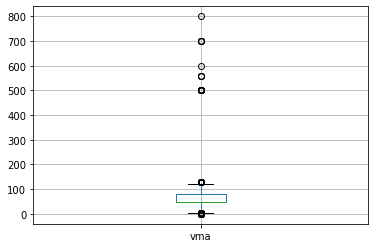

In [37]:
victime.boxplot(column=['vma'])

In [38]:
upper = 130
lower = 10
victime.vma = victime['vma'].clip(lower, upper)

victime.vma.max()

130.0

<AxesSubplot:>

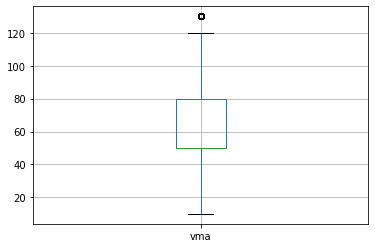

In [39]:
victime.boxplot(column=['vma'])

**Binning**

<AxesSubplot:xlabel='place', ylabel='count'>

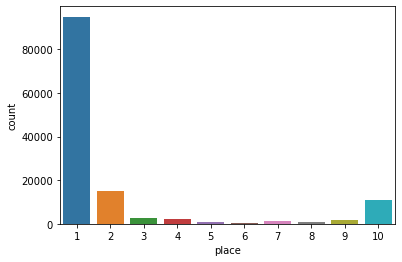

In [40]:
sns.countplot(data=victime, x="place")

On vérifie que la valeur 10 dans 'place' correspond au statut 'pieton'.
On garde les valeurs 1, 2 et 10 de 'place'.

In [41]:
victime.grav.value_counts()*100/len(victime)

1    41.561846
4    40.027986
3    15.759165
2     2.651003
Name: grav, dtype: float64

In [42]:
victime.catu.value_counts()

1    95381
2    23904
3    10779
Name: catu, dtype: int64

In [43]:
victime.num_veh.value_counts()

A01     78630
B01     43597
C01      5328
D01      1126
Z01       793
E01       272
F01       101
Y01        61
G01        42
H01        20
T01        17
I01        16
M01        11
K01         9
J01         8
L01         7
X01         4
W01         4
N01         3
O01         3
U01         2
MA01        2
Q01         2
LB01        1
CB01        1
VF01        1
P01         1
V01         1
\01         1
Name: num_veh, dtype: int64

In [44]:
pd.DataFrame(pd.crosstab(index=victime.Num_Acc, columns = 'count')).sort_values(by='count', ascending=False)

col_0,count
Num_Acc,
201900029632,30
201900049689,28
201900027084,25
201900054644,24
201900057551,24
...,...
201900048228,1
201900011416,1
201900036759,1


In [45]:
victime.catv.value_counts()*100/len(victime)

7     64.193013
33     6.988867
10     6.593677
1      3.917302
2      3.231486
30     2.709435
32     2.120495
31     1.595368
34     1.202485
37     0.991819
3      0.894944
15     0.802682
14     0.684279
17     0.659675
50     0.541272
43     0.418256
99     0.403647
38     0.382888
13     0.367511
21     0.209128
80     0.195288
20     0.190675
0      0.163766
36     0.152233
40     0.146082
60     0.108408
39     0.043056
16     0.033061
42     0.029216
35     0.019990
41     0.009995
Name: catv, dtype: float64

In [46]:
victime.obs.value_counts()*100/len(victime)

0.0     84.010180
1.0      2.315014
13.0     2.117419
2.0      1.739144
3.0      1.632273
4.0      1.532323
6.0      1.283983
8.0      1.250154
14.0     0.781154
12.0     0.748862
15.0     0.616620
9.0      0.472844
16.0     0.453623
7.0      0.335988
11.0     0.213741
17.0     0.177605
5.0      0.175298
10.0     0.143775
Name: obs, dtype: float64

In [47]:
victime.obsm.value_counts()*100/len(victime)

2.0    64.155339
0.0    19.030631
1.0    15.315537
9.0     0.759626
6.0     0.614313
4.0     0.068428
5.0     0.056126
Name: obsm, dtype: float64

In [48]:
victime.plan.value_counts()*100/len(victime)

1.0    81.875077
2.0     8.510426
3.0     8.379721
4.0     1.234777
Name: plan, dtype: float64

In [49]:
victime.choc.value_counts()*100/len(victime)

1.0    36.168348
3.0    15.197903
2.0    12.992834
4.0    10.265715
8.0     6.611361
7.0     5.662597
0.0     5.083651
6.0     3.517499
5.0     2.839371
9.0     1.660721
Name: choc, dtype: float64

In [50]:
victime.manv.value_counts()*100/len(victime)

1.0     42.007012
2.0     11.199102
15.0     7.827685
0.0      5.392730
13.0     4.461650
26.0     3.662812
17.0     3.406016
23.0     2.754029
9.0      2.724044
16.0     2.584881
19.0     2.394206
14.0     2.212757
21.0     1.636118
11.0     1.054865
5.0      0.986437
12.0     0.980287
3.0      0.968754
10.0     0.663519
20.0     0.609700
4.0      0.606624
18.0     0.497447
24.0     0.387502
22.0     0.301390
25.0     0.249877
7.0      0.245264
6.0      0.148388
8.0      0.036905
Name: manv, dtype: float64

In [51]:
victime.motor.value_counts()*100/len(victime)

1.0    82.404047
0.0    10.248032
5.0     3.509042
6.0     1.549237
3.0     1.430834
2.0     0.791918
4.0     0.066890
Name: motor, dtype: float64

In [52]:
victime.an.value_counts()*100/len(victime)

2019    100.0
Name: an, dtype: float64

In [53]:
victime.lum.value_counts()*100/len(victime)

1    66.646420
5    15.819135
3    10.397958
2     6.226934
4     0.909552
Name: lum, dtype: float64

In [54]:
victime.dtypes

Num_Acc          int64
id_vehicule      int64
num_veh         object
place            int64
catu             int64
grav             int64
sexe             int64
secu1          float64
senc           float64
catv             int64
obs            float64
obsm           float64
choc           float64
manv           float64
motor          float64
mois             int64
an               int64
lum              int64
dep            float64
agg              int64
int              int64
atm            float64
col            float64
lat             object
long            object
catr             int64
circ           float64
nbv            float64
vosp           float64
prof           float64
plan           float64
surf           float64
infra          float64
situ           float64
vma            float64
dtype: object

**Décisions de binning :**

- place : on garde 1,2 et 10, le reste "autres" => DONE
- secu1 : On garde, 1,2,8 et0 => DOne
- catv : on garde, 7, 33, 10 => done
- obs : on garde que 0 => Done
- obsm : 0,1,2 on garde => Done
- choc : on garde 1,2,3,4 seuelement => done
- manv : on garde 1 , 2, 15 => done
- motor : on apprend juste que 82% des véhicules sont en hydrocarbure : on supprime la colonne
- an : une seule valeur (l'année 2019) : on supprime la colonne
- lum  : on garde, 1, 5 et 3 => done
- dep : on garde paris, region parisienne et autres => done

In [55]:
victime.drop('an', axis=1, inplace=True)
victime.drop('motor', axis=1, inplace=True)

In [56]:
victime.place.replace([3,4,9,7,5,8,6],'Other', inplace=True)
victime.secu1.replace([3.0,9.0,5.0,6.0,4.0,7.0],'Other', inplace=True)
victime.catv.replace([1,2,30,32,31,34,37,3,15,14,17,50,43,99,38,13,21,80,20,0,36,40,60,39,16,42,35,41],'Other', inplace=True)
victime.obs.replace([1.0,13.0,2.0,3.0,4.0,6.0,8.0,14.0,12.0,15.0,9.0,16.0,7.0,11.0,17.0,5.0,10.0],'Other', inplace=True, regex=True)
victime.obsm.replace([5.0,4.0,6.0,9.0,],'Other', inplace=True, regex=True)
victime.choc.replace([5.0,6.0,9.0,0.0,8.0,7.0],'Other', inplace=True, regex=True)
victime.manv.replace([0.0,13.0,26.0,17.0,23.0,9.0,16.0,19.0,14.0,21.0,11.0,5.0,12.0,3.0,10.0,20.0,4.0,18.0,24.0,22.0,25.0,7.0,6.0,8.0],'Other', inplace=True, regex=True)
victime.lum.replace([2,4],'Other', inplace=True, regex=True)

In [57]:
victime.dep.replace([77.0,78.0,91.0,92.0,93.0,94.0,95.0],'Ile de france', inplace=True)
victime.dep.replace(75.0,'Paris', inplace=True)
other_dep = (victime.dep.value_counts()*100).index[2:]
victime.dep.replace(other_dep,'Other', inplace=True)

In [58]:
victime.dtypes

Num_Acc          int64
id_vehicule      int64
num_veh         object
place           object
catu             int64
grav             int64
sexe             int64
secu1           object
senc           float64
catv            object
obs             object
obsm            object
choc            object
manv            object
mois             int64
lum             object
dep             object
agg              int64
int              int64
atm            float64
col            float64
lat             object
long            object
catr             int64
circ           float64
nbv            float64
vosp           float64
prof           float64
plan           float64
surf           float64
infra          float64
situ           float64
vma            float64
dtype: object

**Observations**

Notre jeu de données a désormais la forme suivante.

In [59]:
victime.shape

(130064, 33)

Conscients du fléau de la dimension, nous savons que le nombre de lignes doit être exponentiellement proportionnel au nombre de features. Nous vérifions ci-dessous que c'est bien le cas.

In [60]:
victime.shape[0]/victime.shape[1]

3941.3333333333335

**Corrélations / Fléau de la dimension**

Recherchons les fortes corrélations entre colonnes (qui sont à éviter). 
Nous fixons à 90% le seuil à partir duquel nous considérons que la corrélation entre 2 colonnes est tellement élevée qu'il convient de supprimer l'une des 2 colonnes.
En l'occurrence, ce seuil n'est atteint pour aucune paire de colonnes, aussi nous n'identifions pas de colonnes redondantes.

<AxesSubplot:>

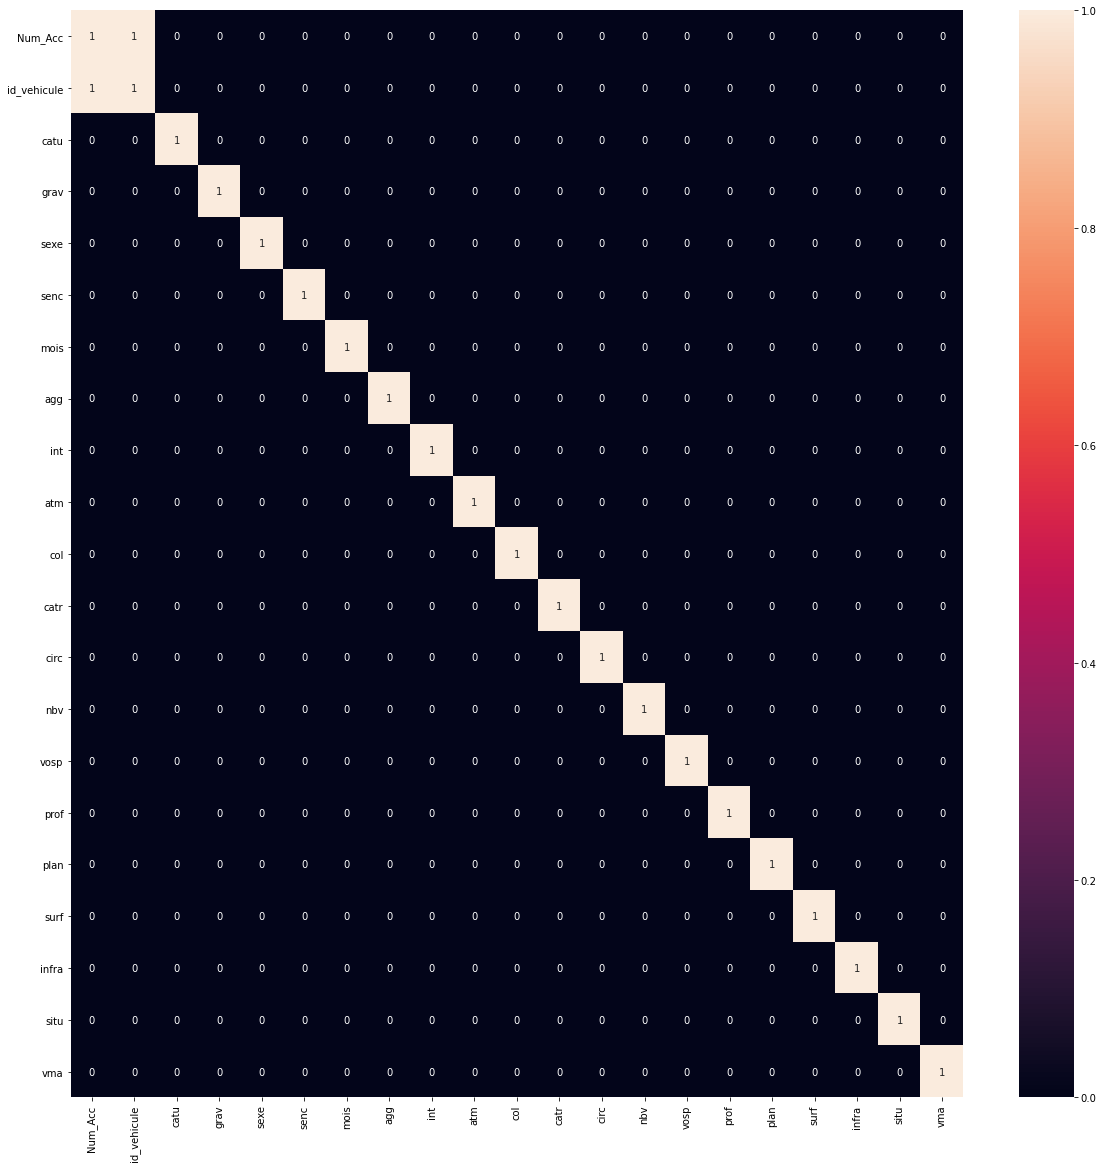

In [61]:
plt.figure(figsize=(20, 20))
sns.heatmap(np.abs(victime.corr())>0.9, annot=True)


**Sur les séries catégorielles : matrice de CRAMER, pas de pearson**


**POUR PANDAS PROFILE et GRAPHIQUES TABLEAU** 

In [62]:
#victime.vma = victime.vma.astype('int')

In [63]:
def convert_to_string(col):
    victime[col] = victime[col].astype(str)
convert_to_string('mois')
convert_to_string('int')
convert_to_string('atm')
convert_to_string('col')
convert_to_string('catr')
convert_to_string('surf')
convert_to_string('infra')
convert_to_string('Num_Acc')
convert_to_string('id_vehicule')
convert_to_string('catu')
convert_to_string('grav')
convert_to_string('sexe')
convert_to_string('senc')
convert_to_string('agg')
convert_to_string('circ')
convert_to_string('vosp')
convert_to_string('prof')
convert_to_string('plan')
convert_to_string('situ')

victime.dtypes

Num_Acc         object
id_vehicule     object
num_veh         object
place           object
catu            object
grav            object
sexe            object
secu1           object
senc            object
catv            object
obs             object
obsm            object
choc            object
manv            object
mois            object
lum             object
dep             object
agg             object
int             object
atm             object
col             object
lat             object
long            object
catr            object
circ            object
nbv            float64
vosp            object
prof            object
plan            object
surf            object
infra           object
situ            object
vma            float64
dtype: object

In [64]:
victime.to_csv('./data/victime_pandas_profile.csv', index=False)

In [65]:
from pandas_profiling import ProfileReport
victime = pd.read_csv("./data/victime_pandas_profile.csv")
victime.dtypes

Num_Acc          int64
id_vehicule      int64
num_veh         object
place           object
catu             int64
grav             int64
sexe             int64
secu1           object
senc           float64
catv            object
obs             object
obsm            object
choc            object
manv            object
mois             int64
lum             object
dep             object
agg              int64
int              int64
atm            float64
col            float64
lat             object
long            object
catr             int64
circ           float64
nbv            float64
vosp           float64
prof           float64
plan           float64
surf           float64
infra          float64
situ           float64
vma            float64
dtype: object

In [66]:
victime.vma.isna().sum()

0

In [67]:
victime.vma.value_counts()

50.0     72535
80.0     20206
70.0      9885
90.0      8710
30.0      7965
110.0     5638
130.0     3713
60.0       481
10.0       343
20.0       282
40.0       120
15.0        61
45.0        53
100.0       30
25.0        19
35.0        11
42.0         4
65.0         4
120.0        2
12.0         2
Name: vma, dtype: int64

In [68]:
def convert_to_string(col):
    victime[col] = victime[col].astype(str)
convert_to_string('mois')
convert_to_string('int')
convert_to_string('atm')
convert_to_string('col')
convert_to_string('catr')
convert_to_string('surf')
convert_to_string('infra')
convert_to_string('Num_Acc')
convert_to_string('id_vehicule')
convert_to_string('catu')
convert_to_string('grav')
convert_to_string('sexe')
convert_to_string('senc')
convert_to_string('agg')
convert_to_string('circ')
convert_to_string('vosp')
convert_to_string('prof')
convert_to_string('plan')
convert_to_string('situ')

victime.dtypes

Num_Acc         object
id_vehicule     object
num_veh         object
place           object
catu            object
grav            object
sexe            object
secu1           object
senc            object
catv            object
obs             object
obsm            object
choc            object
manv            object
mois            object
lum             object
dep             object
agg             object
int             object
atm             object
col             object
lat             object
long            object
catr            object
circ            object
nbv            float64
vosp            object
prof            object
plan            object
surf            object
infra           object
situ            object
vma            float64
dtype: object

**Orphée, j'ai laissé ceci en inopérant pour l'instant, car c'est très long.
C'est ce qui permet de télécharger le rapport Pandas Profile.

#profile_v2 = ProfileReport(victime, title="Pandas Profiling Report")
#profile_v2.to_file("victimes_report.html")

**One-hot-encoding**

On procède à l'encodage des variables catégorielles afin de les transformer en valeurs numériques.

In [69]:
y = victime['grav']

features = victime[['catu', 'sexe', 'senc', 'catv', 'obsm', 'choc',
            'mois', 'lum', 'dep', 'agg', 'atm', 'catr', 'circ','vosp',
           'prof', 'surf', 'infra', 'situ']]

# On garde que les variable catégorielles
X_train_data = pd.get_dummies(features.astype(str), drop_first=True)

In [70]:
X_train_data.shape

(130064, 80)

In [71]:
X_train_data.columns

Index(['catu_2', 'catu_3', 'sexe_2', 'senc_1.0', 'senc_2.0', 'senc_3.0',
       'catv_33', 'catv_7', 'catv_Other', 'obsm_1.0', 'obsm_2.0', 'obsm_Other',
       'choc_2.0', 'choc_3.0', 'choc_4.0', 'choc_Other', 'mois_10', 'mois_11',
       'mois_12', 'mois_2', 'mois_3', 'mois_4', 'mois_5', 'mois_6', 'mois_7',
       'mois_8', 'mois_9', 'lum_3', 'lum_5', 'lum_Other', 'dep_Other',
       'dep_Paris', 'agg_2', 'atm_2.0', 'atm_3.0', 'atm_4.0', 'atm_5.0',
       'atm_6.0', 'atm_7.0', 'atm_8.0', 'atm_9.0', 'catr_2', 'catr_3',
       'catr_4', 'catr_5', 'catr_6', 'catr_7', 'catr_9', 'circ_2.0',
       'circ_3.0', 'circ_4.0', 'vosp_1.0', 'vosp_2.0', 'vosp_3.0', 'prof_2.0',
       'prof_3.0', 'prof_4.0', 'surf_2.0', 'surf_3.0', 'surf_4.0', 'surf_5.0',
       'surf_6.0', 'surf_7.0', 'surf_8.0', 'surf_9.0', 'infra_1.0',
       'infra_2.0', 'infra_3.0', 'infra_4.0', 'infra_5.0', 'infra_6.0',
       'infra_7.0', 'infra_8.0', 'infra_9.0', 'situ_2.0', 'situ_3.0',
       'situ_4.0', 'situ_5.0', 'situ_6

## Machine Learning

In [72]:
from sklearn.model_selection import train_test_split
X = X_train_data
y = victime.grav
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(len(X_train))
print(len(X_test))
#check
len(X_test)+len(X_train)==len(victime)


104051
26013


True

### Choix et Apprentissage de divers Modèles

On essaie 2 modèles de classification : Random Forest et Gradient Boosting.
D'abord en procédant à une évaluation "simple", puis en "cross-validation".

In [73]:
X_trainrf, X_testrf, y_trainrf, y_testrf = train_test_split(X_train_data,y)

model_rf1 = RandomForestClassifier(n_estimators=100,
                                  max_depth=8
                                  )

model_rf1.fit(X_trainrf, y_trainrf)
predictions = model_rf1.predict(X_testrf)
predictions_train = model_rf1.predict(X_trainrf)

In [74]:
# Nous utiliserons le score de Balanced Accuracy ("exactitude pondérée") plutôt que le score d'Accuracy,
# car nos classes cibles sont de tailles respectives déséquilibrées. Pour mémoire :
y.value_counts()*100/len(victime)

1    41.561846
4    40.027986
3    15.759165
2     2.651003
Name: grav, dtype: float64

In [75]:
train_bal_acc = balanced_accuracy_score(y_trainrf, predictions_train)
print("Score de Balanced Accuracy sur le jeu d'entraînement :", train_bal_acc)
test_bal_acc = balanced_accuracy_score(y_testrf, predictions)
print("Score de Balanced Accuracy sur le jeu de test :", test_bal_acc)

0.3925231670098349
0.3873759281423673


In [76]:
# A titre de comparaison :
train_acc = accuracy_score(y_trainrf, predictions_train)
print(" A titre de comparaison, score d'Accuracy sur le jeu d'entraînement :", train_acc)
test_acc = accuracy_score(y_testrf, predictions)
print("A titre de comparaison, score de Balanced Accuracy sur le jeu de test :", test_acc)

0.6041128470086522
0.5937077131258457


**Observations sur le premier modèle**
On a 2 scores d'évaluation proche mais peu élevés (moins de 40% de balanced accuracy). On est dans un cas d'underfitting (algorithme peu performant)

Créons un deuxième modèle.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_train_data,y)

model_boosting = GradientBoostingClassifier(loss="deviance",
    learning_rate=0.2,
    max_depth=5,
    max_features="sqrt",
    subsample=0.95,
    n_estimators=200)

# On lance l'apprentissage :
model_boosting.fit(X_train, y_train)

# On calcule les prédictions
predictions_test_xgb = model_boosting.predict(X_test)
predictions_train_xgb = model_boosting.predict(X_train)

In [78]:
train_bal_acc_xgb = balanced_accuracy_score(y_train, predictions_train_xgb)
print(train_bal_acc_xgb)
test_bal_acc_xgb = balanced_accuracy_score(y_test, predictions_test_xgb)
print(test_bal_acc_xgb)

0.4899541199501334
0.4446050190537302


### Cross-Validation pour améliorer l'évaluation de l'efficacité des modèles

Le jeu d'apprentissage est scindé en 10 "sous-jeux", et l'apprentissage a lieu 10 fois d'affilée sur 9 sous-jeux différents avec une évaluation sur le 10ème sous-jeu. On obtient donc 10 scores distincts d'efficacité, dont on calcule la moyenne et l'écart-type.

In [79]:
# Cross-validation of rf1 using balanced accuracy score
from sklearn.model_selection import cross_val_score

rf1_scores = cross_val_score(model_rf1, X_train, y_train, scoring='balanced_accuracy', cv=10)
def display_scores(scores):
    print("Balanced Accuracy Scores:", scores)
    print("Mean Score:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(rf1_scores)

Scores: [0.39662362 0.38390652 0.39311139 0.39227081 0.38464585 0.38702898
 0.38577717 0.38853766 0.38481696 0.38522495]
Mean: 0.3881943901239797
Standard deviation: 0.004127562033886649


In [80]:
# Cross-validation of model_boosting using balanced accuracy score

boost_scores = cross_val_score(model_boosting, X_train, y_train, scoring='balanced_accuracy', cv=10)
display_scores(boost_scores)

Scores: [0.45149659 0.44129906 0.45114669 0.44411934 0.43499713 0.44846875
 0.44555075 0.45035415 0.44205481 0.44979605]
Mean: 0.4459283307692294
Standard deviation: 0.005085056099217209


**Observation:**
La cross-validation confirme les résultats obtenus plus simplement : le modèle "Gradient Boosting" est plus efficace que le modèle "Random Forest".

Etudions plus finement les hyper-paramètres à utiliser pour améliorer le modèle Gradient Boosting.

### Réglage des Hyperparamètres

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid =  {'n_estimators': [3, 10, 30, 100, 200, 300], 'max_features': [2, 4, 10, 30, 'sqrt', 'log2']}
model_boosting = GradientBoostingClassifier()
grid_search = GridSearchCV(model_boosting, param_grid, cv=5, scoring='balanced_accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_params_

In [ ]:
# Pour sauvegarder notre modèle
import joblib
joblib.dump(grid_search.best_estimator_, "my_model_2021-07-26.pkl")
# Pour le réutiliser
#my_model_loaded = joblib.load("my_model.pkl")

### Variables les plus importantes

Etudions les variables qui sont plus déterminantes que les autres dans la classification par notre modèle.

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
list_feat = list(feature_importances)
list_col = list(X_train_data.columns)
sorted([t for t in zip(list_feat, list_col)], key=lambda t: t[0], reverse=True)

### Evaluation Finale sur le Jeu de Test

In [ ]:
final_model = grid_search.best_estimator_

final_predictions_train = final_model.predict(X_train)
final_predictions_test = final_model.predict(X_test)

final_score_train = balanced_accuracy_score(y_train, final_predictions_train)
final_score_test = balanced_accuracy_score(y_test, final_predictions_test)
print("Final Balanced Accuracy Score on Train Set =", round(final_score_train,3))
print("Final Balanced Accuracy Score on Test Set =", round(final_score_test,3))



**Conclusion :**
Notre modèle le plus performant est assez décevant avec un score de balanced accuracy de 38%.
Pistes d'amélioration : undersampling des 2 classes majoritaires, rajout de features pour complexifier le jeu d'apprentissage, sélection d'autres algorithmes plus complexes.